In [1]:
pip install marimo

  Using cached pymdown_extensions-10.19.1-py3-none-any.whl.metadata (3.1 kB)
  Using cached tomlkit-0.13.3-py3-none-any.whl.metadata (2.8 kB)
  Using cached uvicorn-0.38.0-py3-none-any.whl.metadata (6.8 kB)
  Using cached narwhals-2.13.0-py3-none-any.whl.metadata (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.0/34.0 MB 4.4 MB/s eta 0:00:0000:0100:01
Using cached pymdown_extensions-10.19.1-py3-none-any.whl (266 kB)
Using cached narwhals-2.13.0-py3-none-any.whl (426 kB)
Using cached tomlkit-0.13.3-py3-none-any.whl (38 kB)
Using cached uvicorn-0.38.0-py3-none-any.whl (68 kB)
  Attempting uninstall: narwhals━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  1/10 [uvicorn]
    Found existing installation: narwhals 1.41.0━━━━━━━━━━━━━━  1/10 [uvicorn]
    Uninstalling narwhals-1.41.0:m━━━━━━━━━━━━━━━━━━━━━━━━━━━  3/10 [narwhals]
      Successfully uninstalled narwhals-1.41.0━━━━━━━━━━━━━━━━  3/10 [narwhals]
  Attempting uninstall: anyio╺━━━━━━━━━━━━━━━━━━━  5/10 [markdown]
    Found existing instal

In [4]:
pip install polars

  Using cached polars-1.36.1-py3-none-any.whl.metadata (10 kB)
  Using cached polars_runtime_32-1.36.1-cp39-abi3-macosx_10_12_x86_64.whl.metadata (1.5 kB)
Using cached polars-1.36.1-py3-none-any.whl (802 kB)
Using cached polars_runtime_32-1.36.1-cp39-abi3-macosx_10_12_x86_64.whl (43.5 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [polars]2m1/2 [polars]

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /Users/eshashah/opt/anaconda3/bin/python -m pip install --upgrade pip
ERROR: Exception:
Traceback (most recent call last):
  File "/Users/eshashah/opt/anaconda3/lib/python3.9/site-packages/pip/_internal/cli/base_command.py", line 105, in _run_wrapper
    status = _inner_run()
  File "/Users/eshashah/opt/anaconda3/lib/python3.9/site-packages/pip/_internal/cli/base_command.py", line 96, in _inner_run
    return self.run(options, args)
  File "/Users/eshashah/opt/anaconda3/lib/python3.9/site-packages/pip/_internal/cli/req_command.py", line 68, in wrap

In [8]:
pip install duckdb sqlglot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 4.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 556.4/556.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [duckdb]2m1/2 [duckdb]

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /Users/eshashah/opt/anaconda3/bin/python -m pip install --upgrade pip
ERROR: Exception:
Traceback (most recent call last):
  File "/Users/eshashah/opt/anaconda3/lib/python3.9/site-packages/pip/_internal/cli/base_command.py", line 105, in _run_wrapper
    status = _inner_run()
  File "/Users/eshashah/opt/anaconda3/lib/python3.9/site-packages/pip/_internal/cli/base_command.py", line 96, in _inner_run
    return self.run(options, args)
  File "/Users/eshashah/opt/anaconda3/lib/python3.9/site-packages/pip/_internal/cli/req_command.py", line 68, in wrapper
    return func(self, options, args)
  File "/Users/eshashah/opt/anaconda3/lib/python3.9/site-packages/pip/_internal/c

In [2]:
import marimo as mo

# NFL Metric Development

The goal of this notebook is to develop a metric that calculates the separation being created due to the wide receiver after the ball is thrown.

1. Calculate the raw separation gain (RSG)
2. Calculate the WR-Only Separation (WOS), using a XGBoost regression model.

Each part will be properly defined below.

## Installing Required Libraries & View Data

In [5]:
import pandas as pd
import numpy as np
import plotly.express as px
import altair as alt
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import matplotlib.pyplot as plt
import polars as pl

In [6]:
##Define the files
input_all = "data/input_all.parquet"
output_all = "data/output_all.parquet"
supplementary_data = "data/supplementary_data.parquet"

In [9]:
input_df = mo.sql(
    f"""
    SELECT * FROM '{input_all}'
    """
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [10]:
input_df.head()

game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,player_birth_date,player_position,player_side,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""2023090700""","""101""","""False""","""54527""","""1""","""right""","""42""","""Bryan Cook""","""6-1""","""210""","""1999-09-07""","""FS""","""Defense""","""Defensive Coverage""","""52.33""","""36.94""","""0.09""","""0.39""","""322.4""","""238.24""","""21""","""63.2599983215332""","""-0.219999998807907"""
"""2023090700""","""101""","""False""","""54527""","""2""","""right""","""42""","""Bryan Cook""","""6-1""","""210""","""1999-09-07""","""FS""","""Defense""","""Defensive Coverage""","""52.33""","""36.94""","""0.04""","""0.61""","""200.89""","""236.05""","""21""","""63.2599983215332""","""-0.219999998807907"""
"""2023090700""","""101""","""False""","""54527""","""3""","""right""","""42""","""Bryan Cook""","""6-1""","""210""","""1999-09-07""","""FS""","""Defense""","""Defensive Coverage""","""52.33""","""36.93""","""0.12""","""0.73""","""147.55""","""240.6""","""21""","""63.2599983215332""","""-0.219999998807907"""
"""2023090700""","""101""","""False""","""54527""","""4""","""right""","""42""","""Bryan Cook""","""6-1""","""210""","""1999-09-07""","""FS""","""Defense""","""Defensive Coverage""","""52.35""","""36.92""","""0.23""","""0.81""","""131.4""","""244.25""","""21""","""63.2599983215332""","""-0.219999998807907"""
"""2023090700""","""101""","""False""","""54527""","""5""","""right""","""42""","""Bryan Cook""","""6-1""","""210""","""1999-09-07""","""FS""","""Defense""","""Defensive Coverage""","""52.37""","""36.9""","""0.35""","""0.82""","""123.26""","""244.25""","""21""","""63.2599983215332""","""-0.219999998807907"""


In [11]:
output_df = mo.sql(
    f"""
    SELECT * FROM '{output_all}'
    """
)

In [11]:
supp_df = mo.sql(
    f"""
    SELECT * FROM '{supplementary_data}'
    """
)

## Calculate the Raw Separation Gain (RSG)

1. Calculate the initial distance (yds) from the targeted receiver to the nearest defender at throw.
2. Calculate the same distance at arrival/catch.

In [12]:
throw_df = mo.sql(
    f"""
    -- 1. Define the first moment, the first frame of the output file. The goal is to calculate the distance between the targeted receiver and every defender, then keep the smallest distance per play.

    -- Get the last frame of the input file, and determine the location of each player
    with throw_frames as (
        select *, rank() over (partition by game_id, play_id order by frame_id asc) as rn
        from '{output_all}'
    ),

    roles as (
        select distinct game_id, play_id, nfl_id, player_role
        from '{input_all}'
    ),

    receiver_loc as (
        select a.game_id, a.play_id, a.x::DOUBLE as rx, a.y::DOUBLE as ry
        from throw_frames a
        join roles r
        on a.game_id = r.game_id
        and a.play_id = r.play_id
        and a.nfl_id = r.nfl_id
        where a.rn = 1 and r.player_role = 'Targeted Receiver'
    ),

    defender_locs as (
        select a.game_id, a.play_id, a.x::DOUBLE as dx, a.y::DOUBLE as dy
        from throw_frames a
        join roles r
        on a.game_id = r.game_id
        and a.play_id = r.play_id
        and a.nfl_id = r.nfl_id
        where a.rn = 1 and r.player_role = 'Defensive Coverage'
    )

    select
    r.game_id, r.play_id, min(sqrt(pow(r.rx - d.dx, 2) + pow(r.ry - d.dy, 2))) as sep_at_throw
    from receiver_loc r
    join defender_locs d on r.game_id = d.game_id and r.play_id = d.play_id
    group by r.game_id, r.play_id
    order by r.game_id, r.play_id
    """
)

In [13]:
throw_df.head()

game_id,play_id,sep_at_throw
str,str,f64
"""2023090700""","""1001""",7.324616
"""2023090700""","""101""",4.473299
"""2023090700""","""1069""",6.439161
"""2023090700""","""1154""",10.441935
"""2023090700""","""1201""",2.185635


In [14]:
arrival_df = mo.sql(
    f"""
    -- 2. Calculate the separation at the "Arrival" snapshot, which is the last frame of the output.
    -- Similar logic to the query above but we will have to connect it with the input file to figure out the targeted reciever and the closest defender.
    with arrival_frames as (
        select *, rank() over (partition by game_id, play_id order by frame_id desc) as rn
        from '{output_all}'
    ),

    roles as (
        select distinct game_id, play_id, nfl_id, player_role
        from '{input_all}'
    ),

    receiver_loc as (
        select a.game_id, a.play_id, a.x::DOUBLE as rx, a.y::DOUBLE as ry
        from arrival_frames a
        join roles r
        on a.game_id = r.game_id
        and a.play_id = r.play_id
        and a.nfl_id = r.nfl_id
        where a.rn = 1 and r.player_role = 'Targeted Receiver'
    ),

    defender_locs as (
        select a.game_id, a.play_id, a.x::DOUBLE as dx, a.y::DOUBLE as dy
        from arrival_frames a
        join roles r
        on a.game_id = r.game_id
        and a.play_id = r.play_id
        and a.nfl_id = r.nfl_id
        where a.rn = 1 and r.player_role = 'Defensive Coverage'
    )

    select
    r.game_id, r.play_id, min(sqrt(pow(r.rx - d.dx, 2) + pow(r.ry - d.dy, 2))) as sep_at_arrival
    from receiver_loc r
    join defender_locs d on r.game_id = d.game_id and r.play_id = d.play_id
    group by r.game_id, r.play_id
    order by r.game_id, r.play_id
    """
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [15]:
#Convert it to the pandas dataframe
throw_pd = throw_df.to_pandas()
arrival_pd = arrival_df.to_pandas()

# Merge the two dataframes now to calculate the raw separation gain (RSG)
rsg_df = throw_pd.merge(arrival_pd, on=['game_id', 'play_id'])
rsg_df['raw_sep_gain'] = rsg_df['sep_at_arrival'] - rsg_df['sep_at_throw']

rsg_df.head()

,game_id,play_id,sep_at_throw,sep_at_arrival,raw_sep_gain
0,2023090700,1001,7.324616,6.229286,-1.095330
1,2023090700,101,4.473299,2.478144,-1.995154
2,2023090700,1069,6.439161,5.281534,-1.157628
3,2023090700,1154,10.441935,5.604222,-4.837713
4,2023090700,1201,2.185635,4.118847,1.933212


# Perform Exploratory Data Analysis to better understand the data.

/tmp/ipython-input-2137493823.py:10: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("targeted_plays")


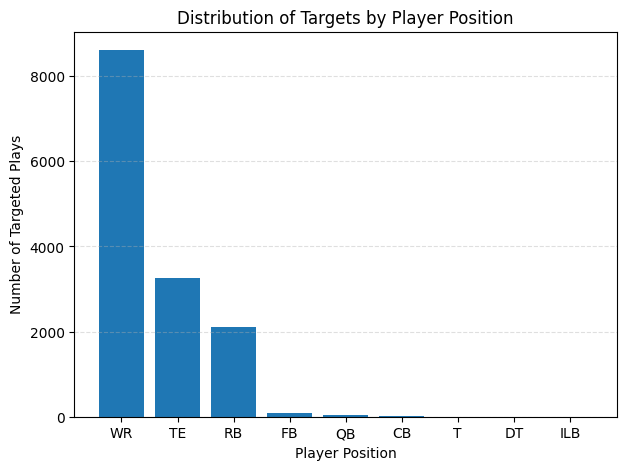

In [16]:
#graph distribution of plays by position

target_counts = (
    input_df
    .filter(pl.col("player_role") == "Targeted Receiver")
    .select(["game_id", "play_id", "player_position"])
    .unique()
    .group_by("player_position")
    .agg(
        pl.count().alias("targeted_plays")
    )
    .sort("targeted_plays", descending=True)
)

target_counts

plot_df = target_counts.to_pandas()
plt.figure(figsize=(7, 5))

plt.bar(
    plot_df["player_position"],
    plot_df["targeted_plays"]
)

plt.xlabel("Player Position")
plt.ylabel("Number of Targeted Plays")
plt.title("Distribution of Targets by Player Position")

plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.show()

The graph shows that the distribution is heavily skewed toward wide receivers, so our model will focus only on plays in which the targeted receiver is a wide receiver. This restriction ensures a sufficiently large and consistent sample size for training, which improves the stability and accuracy of the model.

/tmp/ipython-input-2073135220.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x['pass_result'] == 'C').mean())


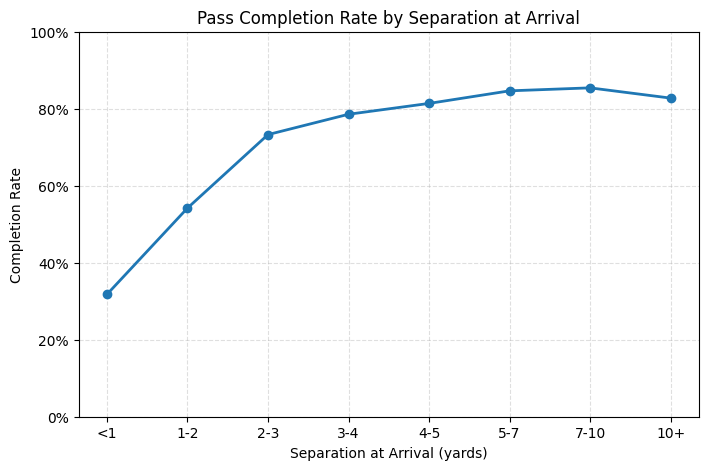

In [17]:
#Find the pass completeion rate by seperation at arrival to see how seperation can influence pass results

# merge supplementary data and rsg to get the pass result and sep_at_arrival in one frame
supp_df = pd.read_parquet(supplementary_data)
df = (
    rsg_df
    .merge(
        supp_df[['game_id', 'play_id', 'pass_result']],
        on=['game_id', 'play_id'],
        how='inner'
    )
)

# ignore sacks and scrambles
df = df[df['pass_result'].isin(['C', 'I', 'IN'])]

# create buckets for sep_at_arrival
bins = [0, 1, 2, 3, 4, 5, 7, 10, np.inf]
labels = ['<1', '1-2', '2-3', '3-4', '4-5', '5-7', '7-10', '10+']

df['sep_bucket'] = pd.cut(
    df['sep_at_arrival'],
    bins=bins,
    labels=labels,
    right=False
)


# calculate completionr rate by bucket
completion_rate = (
    df
    .groupby('sep_bucket', observed=True)
    .apply(lambda x: (x['pass_result'] == 'C').mean())
    .reset_index(name='completion_rate')
)


completion_rate['sep_bucket'] = pd.Categorical(
    completion_rate['sep_bucket'],
    categories=labels,
    ordered=True
)

completion_rate = completion_rate.sort_values('sep_bucket')


# graph completion rate by seperation at arrival
plt.figure(figsize=(8, 5))

plt.plot(
    completion_rate['sep_bucket'],
    completion_rate['completion_rate'],
    marker='o',
    linewidth=2
)

plt.xlabel('Separation at Arrival (yards)')
plt.ylabel('Completion Rate')
plt.title('Pass Completion Rate by Separation at Arrival')

plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.4)

# Format y-axis as percentages
plt.gca().yaxis.set_major_formatter(
    plt.FuncFormatter(lambda y, _: f'{y:.0%}')
)

plt.show()


The graph demonstrates that targeted receivers are more likely to catch a pass when there is greater separation, which reinforces the motivation of our project to quantify how much of that separation is created by the wide receiver. We also observe a decline in completion rate at separations greater than 10 yards, which can likely be attributed to factors such as overthrown or underthrown passes, as well as dropped passes.

In [18]:
#View the sep_at_arrival distribution
fig = px.histogram(rsg_df, x="sep_at_arrival", nbins=50,
                   title="Distribution of Separation Gain (Yards)")
fig.show()

In [19]:
pass_result = mo.sql(
    f"""
    select game_id, play_id, pass_result
    from '{supplementary_data}'
    """
)

In [20]:
#Add the pass result to see how that relates to the raw_sep_gain
pass_result_pd = pass_result.to_pandas()

final_df = rsg_df.merge(pass_result_pd, on = ['game_id', 'play_id'])

rsg_fig = px.histogram(final_df, x = 'sep_at_arrival', color = 'pass_result', nbins=50, barmode = 'overlay', opacity = 0.6, title = "Separation Gain by Pass Result", labels = {"raw_sep_gain": "Separation Gain (Arrival - Throw)"}, category_orders={"pass_result": ["C", "I", "IN"]})

rsg_fig.show()

In [23]:
# --- Data Loading ---
try:
    input_df = pd.read_parquet(input_all)
    output_df = pd.read_parquet(output_all)
    supp_df = pd.read_parquet(supplementary_data)
    print("All dataframes loaded successfully.")
except FileNotFoundError as e:
    raise FileNotFoundError(f"One or more parquet files not found: {e}. Please verify the files exist in the specified FOLDER.")

# --- Ensure numeric columns are numeric ---
motion_cols_input = ['x','y','s','a','dir','o']
motion_cols_output = ['x','y']

for col in motion_cols_input:
    input_df[col] = pd.to_numeric(input_df[col], errors='coerce')
for col in motion_cols_output:
    output_df[col] = pd.to_numeric(output_df[col], errors='coerce')

input_df = input_df.dropna(subset=motion_cols_input)
output_df = output_df.dropna(subset=motion_cols_output)

# --- Compute motion features from input (pre-throw) ---
motion_features_input = input_df.groupby(['game_id','play_id','nfl_id']).agg({
    'x':['mean','max','min','std'],
    'y':['mean','max','min','std'],
    's':['mean','max','min','std'],
    'a':['mean','max','min','std'],
    'dir':['mean','max','min','std'],
    'o':['mean','max','min','std'],
}).reset_index()
motion_features_input.columns = ['game_id','play_id','nfl_id'] + [
    f"{col}_{stat}" for col in ['x','y','s','a','dir','o'] for stat in ['mean','max','min','std']
]

# --- Compute motion features from output (post-throw) ---
motion_features_output = output_df.groupby(['game_id','play_id','nfl_id']).agg({
    'x':['mean','max','min','std'],
    'y':['mean','max','min','std'],
}).reset_index()
motion_features_output.columns = ['game_id','play_id','nfl_id'] + [
    f"{col}_post_{stat}" for col in ['x','y'] for stat in ['mean','max','min','std']
]

motion_features_input_play = motion_features_input.groupby(['game_id','play_id']).mean(numeric_only=True).reset_index()
motion_features_output_play = motion_features_output.groupby(['game_id','play_id']).mean(numeric_only=True).reset_index()

All dataframes loaded successfully.


In [25]:
df = rsg_df.merge(
    supp_df,
    on=["game_id", "play_id"],
    how="inner"
)

# Merge motion features
df = df.merge(
    motion_features_input_play,
    on=['game_id','play_id'],
    how='left'
).merge(
    motion_features_output_play,
    on=['game_id','play_id'],
    how='left'
)

# --- Merge with supplemental contextual features ---
contextual_cols = [
    'down','yards_to_go','offense_formation','receiver_alignment',
    'play_action','dropback_type','dropback_distance',
    'defenders_in_the_box','team_coverage_man_zone','team_coverage_type',
    'pass_length'
]

# Filter supp_df to unique play-level rows for merging
supp_df_unique_plays = supp_df[['game_id','play_id'] + contextual_cols].drop_duplicates(subset=['game_id', 'play_id'])

# Merge, only adding columns from supp_df that are not already in df
cols_to_add_from_supp = [col for col in contextual_cols if col not in df.columns]
df = df.merge(
    supp_df_unique_plays[['game_id','play_id'] + cols_to_add_from_supp],
    on=['game_id','play_id'],
    how='left'
)

print(f"Combined DataFrame shape: {df.shape}")
print(f"Combined DataFrame columns: {df.columns.tolist()}")


Combined DataFrame shape: (12966, 76)
Combined DataFrame columns: ['game_id', 'play_id', 'sep_at_throw', 'sep_at_arrival', 'raw_sep_gain', 'season', 'week', 'game_date', 'game_time_eastern', 'home_team_abbr', 'visitor_team_abbr', 'play_description', 'quarter', 'game_clock', 'down', 'yards_to_go', 'possession_team', 'defensive_team', 'yardline_side', 'yardline_number', 'pre_snap_home_score', 'pre_snap_visitor_score', 'play_nullified_by_penalty', 'pass_result', 'pass_length', 'offense_formation', 'receiver_alignment', 'route_of_targeted_receiver', 'play_action', 'dropback_type', 'dropback_distance', 'pass_location_type', 'defenders_in_the_box', 'team_coverage_man_zone', 'team_coverage_type', 'penalty_yards', 'pre_penalty_yards_gained', 'yards_gained', 'expected_points', 'expected_points_added', 'pre_snap_home_team_win_probability', 'pre_snap_visitor_team_win_probability', 'home_team_win_probability_added', 'visitor_team_win_probility_added', 'x_mean', 'x_max', 'x_min', 'x_std', 'y_mean',

In [27]:
fig = px.histogram(
    df.dropna(subset=['sep_at_throw']),
    x='sep_at_throw',
    nbins=80,
    title="Distribution of Separation at Throw",
    template="plotly_white"
)
fig.show()


The histogram shows that most throws occur with 2–5 yards of separation, which aligns with typical NFL norms. The distribution is right-skewed, with a small number of plays where receivers achieve very high separation (10+ yards), which usually correspond to:

blown coverages

pick plays

scramble drill breakdowns

This graph provides a baseline understanding of what “normal” separation looks like.

In [28]:
fig = px.box(
    df.dropna(subset=['dropback_type', 'sep_at_throw']),
    x='dropback_type',
    y='sep_at_throw',
    title="Separation at Throw by Dropback Type",
    template="plotly_white"
)
fig.update_layout(xaxis_tickangle=-45)
fig.show()

This boxplot shows that scramble and rollout plays create noticeably more separation than traditional dropbacks. Key takeaways:

Designed rollouts (left and right) produce the highest median separation.

Scramble plays also show elevated separation and more high-separation outliers.

Traditional dropbacks consistently produce the lowest separation.

This suggests that moving the pocket helps receivers generate space, likely because defenders must adjust their leverage and pursuit angles mid-play.

In [31]:
fig = px.box(
    df.dropna(subset=['team_coverage_man_zone', 'raw_sep_gain']),
    x='team_coverage_man_zone',
    y='raw_sep_gain',
    title="Separation Delta by Coverage Type (Man vs Zone)",
    template="plotly_white"
)
fig.update_layout(xaxis_tickangle=-45)
fig.show()


Sep delta measures how much separation changes from throw to arrival.

The boxplot shows:

Man coverage tends to produce more negative sep delta, meaning defenders close space by the catch point.

Zone coverage yields flatter or slightly positive deltas, meaning receivers maintain or gain separation as the ball arrives.

This aligns with expected football behavior:

In man coverage, defenders track receivers tightly and often close late.

In zone coverage, receivers find soft spots and maintain space.

Overall, this graph reinforces that coverage scheme strongly affects the dynamics of separation over time.

In [32]:
features = ['sep_at_throw', 'sep_at_arrival', 'raw_sep_gain',
            'yards_to_go', 'pass_length', 'defenders_in_the_box']

corr = df[features].corr()

fig = px.imshow(corr, text_auto=True, title="Correlation Heatmap")
fig.show()


In [33]:
fig = px.box(df, x='pass_result', y='sep_at_throw',
             title="Separation at Throw by Pass Result")
fig.update_layout(xaxis_tickangle=-45)
fig.show()

In [35]:
motion_variability_features = [
    'raw_sep_gain', 's_std', 'a_std', 'dir_std', 'o_std',
    'x_post_std', 'y_post_std'
]

# Calculate the correlation matrix
corr_motion_variability = df[motion_variability_features].corr()

# Display the correlation matrix as a heatmap
fig = px.imshow(
    corr_motion_variability,
    text_auto=True,
    title="Correlation Heatmap: Separation Delta vs. Motion Variability",
    template="plotly_white"
)
fig.show()